In [1]:
import torch, pickle, argparse, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import ConvNet
from data_loader import load_test_data
from tqdm.notebook import tqdm
from mlflow.tracking.artifact_utils import get_artifact_uri

In [2]:
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(1669397724)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)

checkpoint = 'untrained.ckpt'
checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])
model = ConvNet(hparams, None, None).eval()
model.load_state_dict(best_model['state_dict'])

TEST_PATH = "s2_mnist_cs1.gz"
test_data = load_test_data(TEST_PATH)

In [3]:
def trafo(images, lower=0, upper=255):
    b = upper - lower
    a = upper/b - 1
    return (images + a)*b

In [4]:
max_el = 255
L = 60
c = 1/(max_el*L)

In [5]:
images = test_data[:][0]
dist2_data = c*torch.cdist(images.view(images.size(0), -1), torch.zeros(images[0].view(1,-1).size()), p=2)
r_sample_uniform = torch.rand(10000,1,60,60)
dist2_uniform = c*torch.cdist(r_sample_uniform.view(r_sample_uniform.size(0), -1), torch.zeros(r_sample_uniform[0].view(1,-1).size()), p=2)
std_data, mean_data = torch.std_mean(dist2_data)
std_uniform, mean_uniform = torch.std_mean(dist2_uniform)
ones = torch.ones(1,1,60,60)*255
dist2_ones = c*torch.dist(ones.flatten(), torch.zeros(ones.flatten().size()), p=2)
zeros = torch.zeros(1,1,60,60)

In [6]:
bs = 1000

logits_data = torch.stack([model(images[i*bs:bs*(i+1)]).detach().cpu() for i in range(10000//bs)]).reshape(-1, 10)

In [7]:
std_logits_data, mean_logits_data = torch.std_mean(logits_data, dim=-2)

In [8]:
uppers = [i/5*255 for i in range(1,6)]
lowers = [i/5*255 for i in range(1,5)]

In [9]:
logits_uniform = []

for upper in tqdm(uppers):
    logits_uniform.append(torch.stack([model(trafo(r_sample_uniform[i*bs:bs*(i+1)], upper=upper)).detach().cpu() for i in range(10000//bs)]).reshape(-1, 10))
    
for lower in tqdm(lowers):
    logits_uniform.append(torch.stack([model(trafo(r_sample_uniform[i*bs:bs*(i+1)], lower=lower)).detach().cpu() for i in range(10000//bs)]).reshape(-1, 10))

logits_uniform = torch.stack(logits_uniform)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
logits_zeros = model(zeros).detach().cpu()
logits_ones = model(ones).detach().cpu()

In [11]:
std_logits_uniform, mean_logits_uniform = torch.std_mean(logits_uniform, dim=-2)
mean_logits_zeros = torch.mean(logits_zeros, dim=-2)
mean_logits_ones = torch.mean(logits_ones, dim=-2)

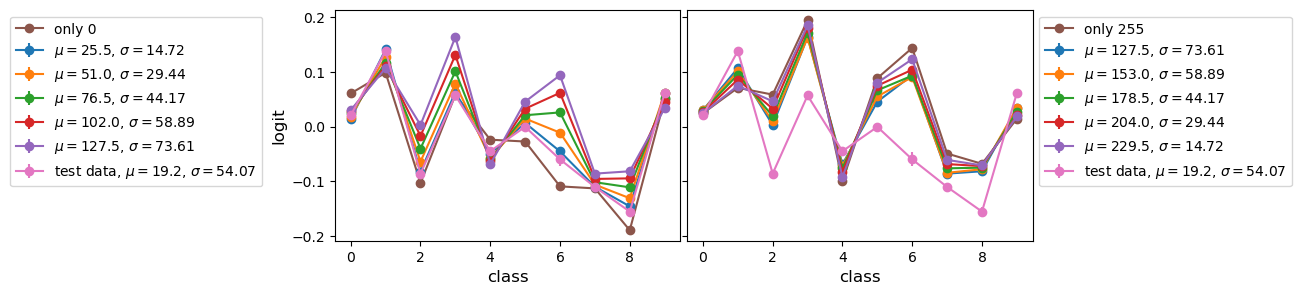

In [26]:
fontsize = 12
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (9, 3), sharey=True, gridspec_kw={'wspace':0.02, 'hspace':0})

for i in range(5):
    axs[0].errorbar(torch.arange(10), mean_logits_uniform[i], yerr=std_logits_uniform[i], linestyle='-', marker='o', label=f'$\mu = ${torch.mean(trafo(r_sample_uniform, upper=uppers[i])):{1}.{4}}, $\sigma = ${torch.std(trafo(r_sample_uniform, upper=uppers[i])):{1}.{4}}')

axs[1].errorbar(torch.arange(10), mean_logits_uniform[4], yerr=std_logits_uniform[4], linestyle='-', marker='o', label=f'$\mu = ${torch.mean(trafo(r_sample_uniform, upper=uppers[4])):{1}.{4}}, $\sigma = ${torch.std(trafo(r_sample_uniform, upper=uppers[4])):{1}.{4}}')
for i in range(5,9):
    axs[1].errorbar(torch.arange(10), mean_logits_uniform[i], yerr=std_logits_uniform[i], linestyle='-', marker='o', label=f'$\mu = ${torch.mean(trafo(r_sample_uniform, lowers[i-5])):{1}.{4}}, $\sigma = ${torch.std(trafo(r_sample_uniform, lowers[i-5])):{1}.{4}}')
    
axs[0].plot(torch.arange(10), mean_logits_zeros, linestyle='-', marker='o', label='only 0')
axs[1].plot(torch.arange(10), mean_logits_ones, linestyle='-', marker='o', label='only 255')
for j in range(2):
    axs[j].errorbar(torch.arange(10), mean_logits_data, yerr=std_logits_data, linestyle='-', marker='o', label=f'test data, $\mu = ${torch.mean(images):{1}.{4}}, $\sigma = ${torch.std(images):{1}.{4}}')
    axs[j].set_xlabel('class', fontsize=fontsize)

axs[0].set_ylabel('logit', fontsize=fontsize)
axs[0].legend(bbox_to_anchor=(-0.19,1))
axs[1].legend(bbox_to_anchor=(1,1))

# plt.savefig('logits_untrained_CNN_uniform.pdf', bbox_inches="tight")
plt.show()

In [14]:
dist1_data = torch.cdist(images.view(images.size(0), -1), torch.zeros(images[0].view(1,-1).size()), p=1)/3600
print(torch.mean(dist1_data))

In [17]:
labels = test_data[:][1]

mean_per_digit = torch.stack([torch.mean(images[labels==i]) for i in range(10)])
std_per_digit = torch.stack([torch.std(images[labels==i]) for i in range(10)])

logits_per_digit = [model(images[labels==i]).detach().cpu() for i in range(10)]
std_mean_logits_per_digit = torch.stack([torch.stack(torch.std_mean(logits_per_digit[i], dim=-2)) for i in range(10)])

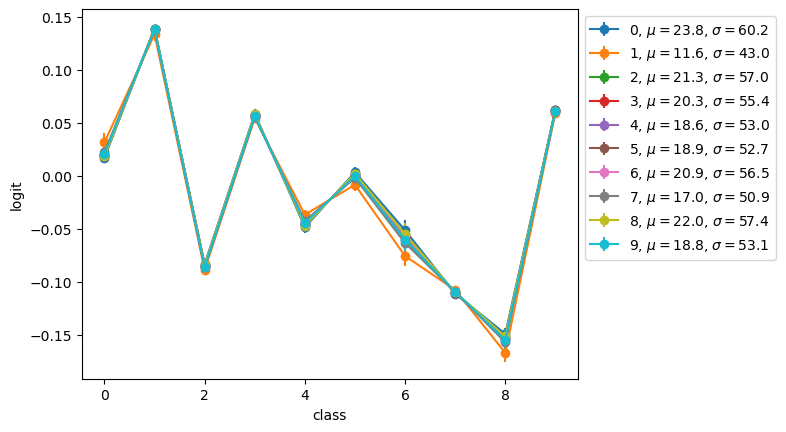

In [25]:
for i in range(10):
    plt.errorbar(torch.arange(10), std_mean_logits_per_digit[i,1], yerr=std_mean_logits_per_digit[i,0], linestyle='-', marker='o', label=f'{i}, $\mu = {mean_per_digit[i]:{1}.{3}}$, $\sigma = {std_per_digit[i]:{1}.{3}}$')
    
plt.xlabel('class')
plt.ylabel('logit')
plt.legend(bbox_to_anchor=(1,1))

# plt.savefig('logits_untrained_CNN_test_data.pdf', bbox_inches="tight")
plt.show()